# 라이브러리 불러오기

In [26]:
!pip install torch transformers peft

In [27]:
# 필요한 라이브러리 설치
import numpy as np
import pandas as pd
import torch
from peft import LoraConfig, get_peft_model
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, TensorDataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.model_selection import train_test_split
import re
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
import scipy.sparse as sp
import seaborn as sns

# 데이터 불러오기

In [28]:
# 데이터 로드
train_path = "/kaggle/input/nlp-getting-started/train.csv"
test_path = "/kaggle/input/nlp-getting-started/test.csv"
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [29]:
# 학습 데이터의 구조 확인
train_df[:50]  

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


# 데이터 분석

## 1) 결측치 분석

In [30]:
# `keyword`와 `location` 열에 결측치(`NaN`)가 많으므로 이를 어떻게 처리할지 결정하기 위해 결측치 분석 
print(train_df.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


## 2) target 열의 데이터 분포 분석

In [31]:
# 'target' 열의 데이터 분포 확인하여 데이터가 균형이 잡혀있는지 판단
print(train_df['target'].value_counts(normalize=True))

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


## 3) 재난/비재난의 텍스트 길이 분석

전체 텍스트 길이 통계:
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_length, dtype: float64

재난 트윗 길이 통계:
count    3271.000000
mean      108.113421
std        29.309854
min        14.000000
25%        88.000000
50%       115.000000
75%       136.000000
max       151.000000
Name: text_length, dtype: float64

비재난 트윗 길이 통계:
count    4342.000000
mean       95.706817
std        35.885924
min         7.000000
25%        68.000000
50%       101.000000
75%       130.000000
max       157.000000
Name: text_length, dtype: float64


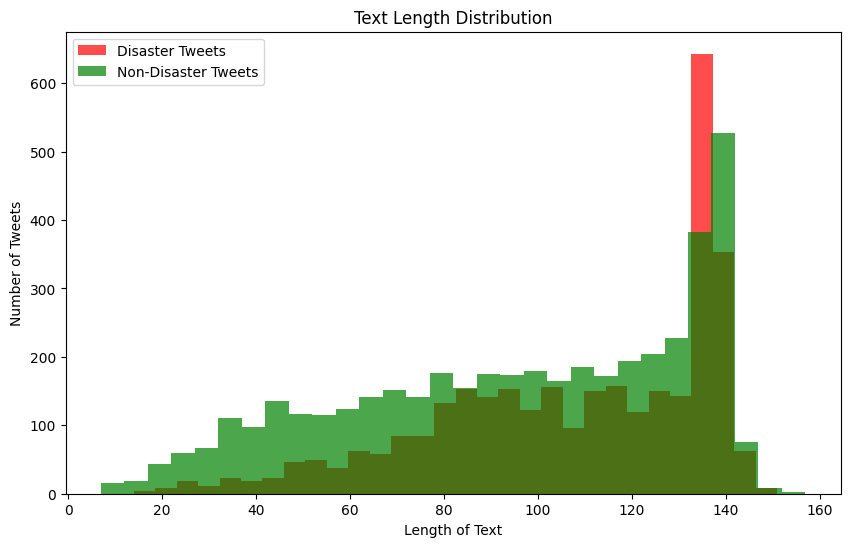

In [32]:
# 텍스트 길이 분석
train_df['text_length'] = train_df['text'].apply(len)

# 길이 통계
print("전체 텍스트 길이 통계:")
print(train_df['text_length'].describe())

# 재난/비재난별 텍스트 길이 분포
print("\n재난 트윗 길이 통계:")
print(train_df[train_df['target'] == 1]['text_length'].describe())

print("\n비재난 트윗 길이 통계:")
print(train_df[train_df['target'] == 0]['text_length'].describe())

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
plt.hist(train_df[train_df['target'] == 1]['text_length'], bins=30, alpha=0.7, label='Disaster Tweets', color='red')
plt.hist(train_df[train_df['target'] == 0]['text_length'], bins=30, alpha=0.7, label='Non-Disaster Tweets', color='green')
plt.title('Text Length Distribution')
plt.xlabel('Length of Text')
plt.ylabel('Number of Tweets')
plt.legend()
plt.show()


## 4-1) 재난/비재난의 단어 빈도 분석

In [33]:
# 텍스트 정제 함수
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # URL 제거
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # 특수문자 제거
    text = text.lower()  # 소문자로 변환
    return text

# 정제된 텍스트 추가
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)

# 재난 및 비재난 트윗 나누기
disaster_texts = train_df[train_df['target'] == 1]['cleaned_text']
nondisaster_texts = train_df[train_df['target'] == 0]['cleaned_text']

# 단어 빈도 계산 함수
def get_word_frequencies(texts):
    all_words = " ".join(texts).split()
    return Counter(all_words)

# 단어 빈도 계산
disaster_word_freq = get_word_frequencies(disaster_texts)
nondisaster_word_freq = get_word_frequencies(nondisaster_texts)

# 가장 자주 등장한 단어 10개
print("재난 트윗 상위 10개 단어:")
print(disaster_word_freq.most_common(10))

print("\n비재난 트윗 상위 10개 단어:")
print(nondisaster_word_freq.most_common(10))

재난 트윗 상위 10개 단어:
[('the', 1362), ('in', 1161), ('of', 927), ('a', 926), ('to', 757), ('and', 502), ('on', 417), ('for', 399), ('is', 349), ('at', 308)]

비재난 트윗 상위 10개 단어:
[('the', 1909), ('a', 1257), ('to', 1189), ('i', 1078), ('and', 918), ('of', 901), ('in', 818), ('you', 667), ('is', 595), ('my', 544)]


## 4-2) stopwords를 제거한 후 재난/비재난의 단어 빈도 분석

In [34]:
# stopwords(불용어) 제거 후 단어 빈도 계산
def get_word_frequencies_no_stopwords(texts):
    all_words = " ".join(texts).split()
    filtered_words = [word for word in all_words if word not in ENGLISH_STOP_WORDS]
    return Counter(filtered_words)

# 재난/비재난 텍스트에 적용
disaster_word_freq_no_stopwords = get_word_frequencies_no_stopwords(disaster_texts)
nondisaster_word_freq_no_stopwords = get_word_frequencies_no_stopwords(nondisaster_texts)

# 결과 출력
print("stopwords 제거 후 재난 트윗 상위 10개 단어:")
print(disaster_word_freq_no_stopwords.most_common(10))

print("\nstopwords 제거 후 비재난 트윗 상위 10개 단어:")
print(nondisaster_word_freq_no_stopwords.most_common(10))

stopwords 제거 후 재난 트윗 상위 10개 단어:
[('news', 136), ('disaster', 117), ('california', 111), ('suicide', 110), ('police', 107), ('amp', 106), ('people', 105), ('killed', 93), ('like', 92), ('just', 86)]

stopwords 제거 후 비재난 트윗 상위 10개 단어:
[('like', 253), ('im', 248), ('just', 234), ('amp', 192), ('new', 170), ('dont', 154), ('body', 113), ('video', 96), ('people', 91), ('love', 90)]


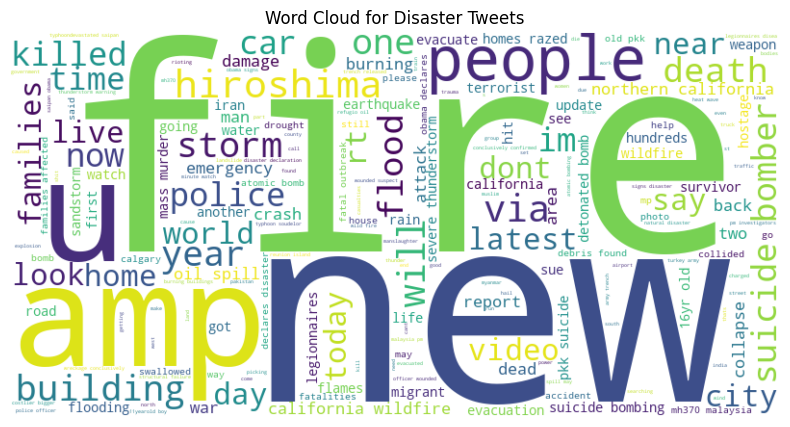

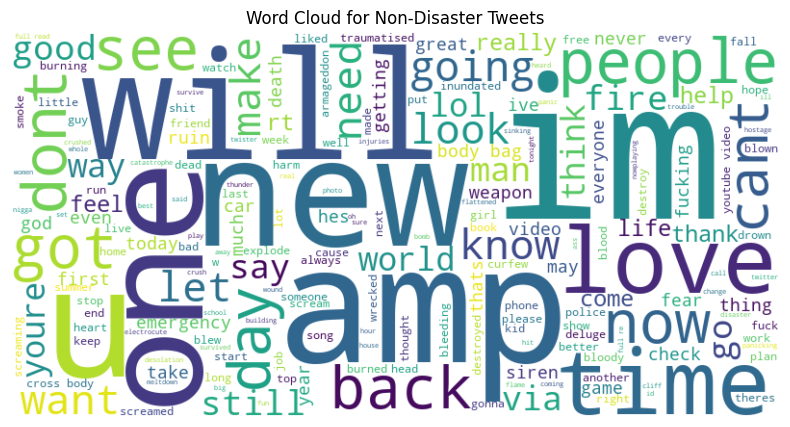

In [35]:
# 재난 트윗 Word Cloud
disaster_text = " ".join(disaster_texts)
wordcloud_disaster = WordCloud(width=800, height=400, background_color="white").generate(disaster_text)

plt.figure(figsize=(10, 5))
plt.title("Word Cloud for Disaster Tweets")
plt.imshow(wordcloud_disaster, interpolation="bilinear")
plt.axis("off")
plt.show()

# 비재난 트윗 Word Cloud
nondisaster_text = " ".join(nondisaster_texts)
wordcloud_nondisaster = WordCloud(width=800, height=400, background_color="white").generate(nondisaster_text)

plt.figure(figsize=(10, 5))
plt.title("Word Cloud for Non-Disaster Tweets")
plt.imshow(wordcloud_nondisaster, interpolation="bilinear")
plt.axis("off")
plt.show()

## 5) 해시태그/특수문자가 재난/비재난 트윗에 미치는 여부 분석

In [36]:
# 해시태그 포함 여부
train_df['has_hashtag'] = train_df['text'].str.contains(r'#').astype(int)

# 특수문자 포함 여부
train_df['has_special_char'] = train_df['text'].str.contains(r'[^A-Za-z0-9\s]').astype(int)

# 해시태그 및 특수문자 통계
print("재난 트윗에서 해시태그 포함 비율:")
print(train_df[train_df['target'] == 1]['has_hashtag'].mean())

print("비재난 트윗에서 해시태그 포함 비율:")
print(train_df[train_df['target'] == 0]['has_hashtag'].mean())

print("재난 트윗에서 특수문자 포함 비율:")
print(train_df[train_df['target'] == 1]['has_special_char'].mean())

print("비재난 트윗에서 특수문자 포함 비율:")
print(train_df[train_df['target'] == 0]['has_special_char'].mean())


재난 트윗에서 해시태그 포함 비율:
0.2675022928767961
비재난 트윗에서 해시태그 포함 비율:
0.20405343159834177
재난 트윗에서 특수문자 포함 비율:
0.9810455518190155
비재난 트윗에서 특수문자 포함 비율:
0.937125748502994


## 6) location 열 결측치와 고유값 분석

In [37]:
# 결측치 확인
print("결측치 개수:", train_df['location'].isnull().sum())

# 전체 location 값의 고유 값 확인
print("고유 location 값의 개수:", train_df['location'].nunique())

# 상위 10개의 location 확인
print("가장 많이 등장한 location 상위 10개:")
print(train_df['location'].value_counts().head(10))

결측치 개수: 2533
고유 location 값의 개수: 3341
가장 많이 등장한 location 상위 10개:
location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: count, dtype: int64


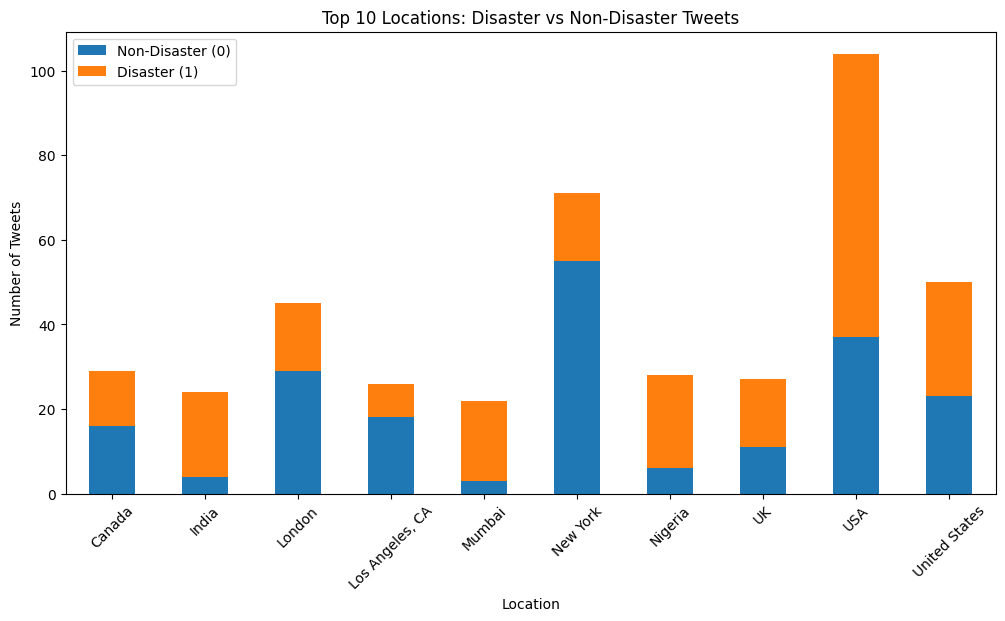

In [38]:
# 상위 10개 location 추출
top_locations = train_df['location'].value_counts().head(10).index

# 해당 location에서 재난/비재난 비율 계산
top_locations_data = train_df[train_df['location'].isin(top_locations)]
top_location_counts = top_locations_data.groupby(['location', 'target']).size().unstack()

# 막대 그래프로 시각화
top_location_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Top 10 Locations: Disaster vs Non-Disaster Tweets")
plt.xlabel("Location")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.legend(["Non-Disaster (0)", "Disaster (1)"])
plt.show()

## 7) 문장의 감정이 영향을 미치는지 분석

In [39]:
# 감정 점수 계산 함수
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity  # 감정 점수 (-1 ~ 1)
    return polarity

# train_df와 test_df에 감정 점수 추가
train_df['sentiment'] = train_df['text'].apply(get_sentiment)
test_df['sentiment'] = test_df['text'].apply(get_sentiment)

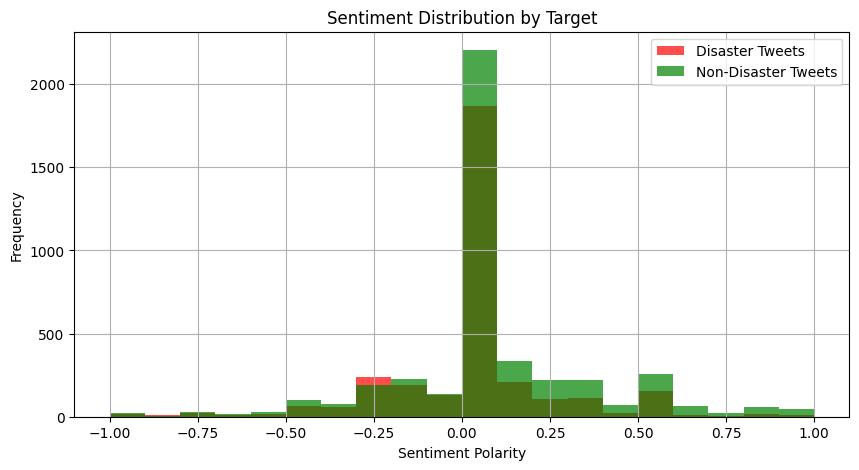

In [40]:
# 재난 트윗과 비재난 트윗의 감정 점수 분포 시각화
plt.figure(figsize=(10, 5))
train_df[train_df['target'] == 1]['sentiment'].hist(alpha=0.7, bins=20, label='Disaster Tweets', color='red')
train_df[train_df['target'] == 0]['sentiment'].hist(alpha=0.7, bins=20, label='Non-Disaster Tweets', color='green')
plt.title('Sentiment Distribution by Target')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [41]:
# 재난 트윗과 비재난 트윗의 평균 감정 점수
disaster_mean_sentiment = train_df[train_df['target'] == 1]['sentiment'].mean()
non_disaster_mean_sentiment = train_df[train_df['target'] == 0]['sentiment'].mean()

print("재난 트윗의 평균 감정 점수:", disaster_mean_sentiment)
print("비재난 트윗의 평균 감정 점수:", non_disaster_mean_sentiment)

재난 트윗의 평균 감정 점수: 0.018630886023986618
비재난 트윗의 평균 감정 점수: 0.07062221768678355


In [42]:
# 텍스트를 TF-IDF로 변환
tfidf = TfidfVectorizer(max_features=1000)  # 빠른 처리를 위해 피처 수 제한
X_tfidf = tfidf.fit_transform(train_df['text'])

# 감정 점수와 결합
X_with_sentiment = sp.hstack([X_tfidf, train_df[['sentiment']].values])

# 타겟 변수
y = train_df['target']

# 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X_with_sentiment, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 학습
model_with_sentiment = LogisticRegression()
model_with_sentiment.fit(X_train, y_train)

# 예측 및 평가
y_pred_with_sentiment = model_with_sentiment.predict(X_val)
print("Accuracy (With Sentiment):", accuracy_score(y_val, y_pred_with_sentiment))
print("Classification Report (With Sentiment):\n", classification_report(y_val, y_pred_with_sentiment))

Accuracy (With Sentiment): 0.7997373604727511
Classification Report (With Sentiment):
               precision    recall  f1-score   support

           0       0.80      0.87      0.83       874
           1       0.80      0.71      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [43]:
# 텍스트만 사용한 TF-IDF
X_without_sentiment = X_tfidf  # 감정 점수 제외

# 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X_without_sentiment, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 학습
model_without_sentiment = LogisticRegression()
model_without_sentiment.fit(X_train, y_train)

# 예측 및 평가
y_pred_without_sentiment = model_without_sentiment.predict(X_val)
print("Accuracy (Without Sentiment):", accuracy_score(y_val, y_pred_without_sentiment))
print("Classification Report (Without Sentiment):\n", classification_report(y_val, y_pred_without_sentiment))


Accuracy (Without Sentiment): 0.7971109652002626
Classification Report (Without Sentiment):
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       874
           1       0.80      0.69      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



# 데이터 전처리

In [44]:
# 데이터 로드
train_path = "/kaggle/input/nlp-getting-started/train.csv"
test_path = "/kaggle/input/nlp-getting-started/test.csv"
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [45]:
# feature와 target을 분리
y = train_df['target']
X = train_df.drop(columns=['target'])

In [46]:
# 결측치 처리
X['keyword'] = X['keyword'].fillna('[UNK]')
X['location'] = X['location'].fillna('[UNK]')
test_df['keyword'] = test_df['keyword'].fillna('[UNK]')
test_df['location'] = test_df['location'].fillna('[UNK]')

In [47]:
# 텍스트 정제 함수
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # URL 제거
    text = re.sub(r'@\w+', '', text)  # 멘션 제거
    text = re.sub(r'#(\w+)', r'\1', text)  # 해시태그 처리
    text = text.lower()  # 소문자로 변환
    text = re.sub(r'\[unk\]', 'PLACEHOLDERUNK', text)  # UNK 임시 처리
    text = re.sub(r'[^A-Za-z\s]', '', text)  # 알파벳과 공백 제외 문자 제거
    text = re.sub(r'PLACEHOLDERUNK', '[UNK]', text)  # UNK 복원
    text = re.sub(r'\s+', ' ', text).strip()  # 중복 공백 제거
    return text
    
# 텍스트 정제 적용 
X['text'] = X['text'].apply(clean_text)
X['keyword'] = X['keyword'].apply(clean_text)
X['location'] = X['location'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)
test_df['keyword'] = test_df['keyword'].apply(clean_text)
test_df['location'] = test_df['location'].apply(clean_text)

In [48]:
# 입력 데이터 결합
X['combined'] = '[KEYWORD] ' + X['keyword'] + ' [LOCATION] ' + X['location'] + ' [TEXT] ' + X['text']
test_df['combined'] = '[KEYWORD] ' + test_df['keyword'] + ' [LOCATION] ' + test_df['location'] + ' [TEXT] ' + test_df['text']

In [49]:
X[:50]

,id,keyword,location,text,combined
0,1,[UNK],[UNK],our deeds are the reason of this earthquake ma...,[KEYWORD] [UNK] [LOCATION] [UNK] [TEXT] our de...
1,4,[UNK],[UNK],forest fire near la ronge sask canada,[KEYWORD] [UNK] [LOCATION] [UNK] [TEXT] forest...
2,5,[UNK],[UNK],all residents asked to shelter in place are be...,[KEYWORD] [UNK] [LOCATION] [UNK] [TEXT] all re...
3,6,[UNK],[UNK],people receive wildfires evacuation orders in ...,[KEYWORD] [UNK] [LOCATION] [UNK] [TEXT] people...
4,7,[UNK],[UNK],just got sent this photo from ruby alaska as s...,[KEYWORD] [UNK] [LOCATION] [UNK] [TEXT] just g...
5,8,[UNK],[UNK],rockyfire update california hwy closed in both...,[KEYWORD] [UNK] [LOCATION] [UNK] [TEXT] rockyf...
6,10,[UNK],[UNK],flood disaster heavy rain causes flash floodin...,[KEYWORD] [UNK] [LOCATION] [UNK] [TEXT] flood ...
7,13,[UNK],[UNK],im on top of the hill and i can see a fire in ...,[KEYWORD] [UNK] [LOCATION] [UNK] [TEXT] im on ...
8,14,[UNK],[UNK],theres an emergency evacuation happening now i...,[KEYWORD] [UNK] [LOCATION] [UNK] [TEXT] theres...
9,15,[UNK],[UNK],im afraid that the tornado is coming to our area,[KEYWORD] [UNK] [LOCATION] [UNK] [TEXT] im afr...


# 모델 및 토크나이저 로드

In [50]:
# 사전 학습된 'roberta-base' 토크나이저 로드
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', clean_up_tokenization_spaces=False) 

# 텍스트를 토크나이징하는 함수 정의
def tokenize_texts(texts, labels=None):
    """
    토크나이저를 사용해 입력 텍스트를 토큰화
    """
    tokenized_data = tokenizer(
        texts,  # 입력으로 전달된 텍스트 리스트
        padding="max_length",  # 입력 길이를 최대 길이에 맞춰 패딩
        truncation=True,  # 초과된 텍스트 잘라냄
        return_tensors='pt'  # PyTorch 텐서 형태로 반환
    )
    # labels가 제공된 경우(train/validation에 해당)
    if labels is not None:
        # 'input_ids', 'attention_mask', 'labels'를 텐서로 변환하여 반환
        return tokenized_data['input_ids'], tokenized_data['attention_mask'], torch.tensor(labels)
    # labels이 제공되지 않은 경우 'input_ids'와 'attention_mask'만 반환
    return tokenized_data['input_ids'], tokenized_data['attention_mask']

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [51]:
# 사전 학습된 'roberta-large' 모델 로드
model = RobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=2) #num_labels=2: 분류 작업에서 두 개의 클래스(0/1)를 처리하도록 함

# LoRA를 적용할 대상 모듈 지정
"""
LoRA에서 query, key, value는 self-attention의 핵심 매개변수로, 모델의 성능에 큰 영향을 미침.
전체 모델의 파라미터를 업데이트 하지 않고, self-attention의 일부 모듈을 학습하게 함으로써 계산 비용과 메모리 사용량을 줄이고자 LoRA를 적용함.
"""
target_modules = [] # LoRA를 적용할 모듈의 이름을 저장하는 리스트를 초기화
for layer in range(24): #  RoBERTa의 총 24개의 Transformer 레이어를 순회
    for sub_module in ['query', 'key', 'value']: # 각 레이어의 self-attention 메커니즘에서 query, key, value라는 서브 모듈을 순회
        target_modules.append(f'roberta.encoder.layer.{layer}.attention.self.{sub_module}')

# LoRA 적용을 위해 LoRAConfig 객체 생성
lora_config = LoraConfig(
    target_modules=target_modules,
    r=4,  # 저차원 어댑터의 랭크(r). 이 값이 클수록 모델의 표현력이 높아지지만 계산 비용도 증가
    lora_alpha=128,  # LoRA의 확장 비율. 학습된 저차원 어댑터를 확장하는 데 사용
    lora_dropout=0.1 # LoRA가 적용되는 모듈에 드롭아웃(dropout)을 적용하여 과적합 방지
)

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 데이터 준비

In [52]:
# 데이터 분할 
X_train, X_val, y_train, y_val = train_test_split(X['combined'], y, test_size=0.2, random_state=42) # 데이터를 학습용와 검증용으로 분할 (8:2)

# 토크나이징을 통해 데이터를 숫자로 변환하여 모델이 처리할 수 있는 형식으로 입력 데이터를 변경
"""
inputs: 텍스트를 숫자로 변환한 토큰 ID.
masks: 모델이 패딩(padding)된 부분을 무시하도록 알려주는 마스크.
labels: 분류 문제에서 사용할 타겟(label) 데이터.
"""
train_inputs, train_masks, train_labels = tokenize_texts(X_train.tolist(), y_train.tolist()) 
val_inputs, val_masks, val_labels = tokenize_texts(X_val.tolist(), y_val.tolist())
test_inputs, test_masks = tokenize_texts(test_df['combined'].tolist())

In [53]:
# 데이터셋 준비
"""
학습 데이터, 검증 데이터, 테스트 데이터를 PyTorch의 TensorDataset으로 생성
TensorDataset: 입력(inputs), 마스크(masks), 라벨(labels)을 묶어 데이터셋으로 관리
"""
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)  # 학습 데이터셋
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)          # 검증 데이터셋
test_dataset = TensorDataset(test_inputs, test_masks)                  # 테스트 데이터셋 (labels 없음)

In [54]:
# 데이터셋을 배치(batch) 단위로 모델에 공급할 수 있도록 데이터 로더 준비
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True) # 학습 데이터에서 샘플을 무작위로 섞은 후, batch_size 단위로 나누어 모델에 전달
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False) # 검증 데이터에서 순서대로 batch_size 단위로 나누어 모델에 전달
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False) # 평가 데이터에서 순서대로 batch_size 단위로 나누어 모델에 전달

# LoRA 적용

In [55]:
# LoRA 모델 생성
lora_model = get_peft_model(model, lora_config)

In [56]:
# device 설정 (GPU(CUDA)가 사용 가능한 경우 "cuda"를 사용하고, 그렇지 않으면 "cpu＂로 설정)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
# 모델을 device로 이동
lora_model.to(device)

PeftModel(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 1024, padding_idx=1)
          (position_embeddings): Embedding(514, 1024, padding_idx=1)
          (token_type_embeddings): Embedding(1, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-23): 24 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
          

# 기타 설정 적용

In [57]:
# Adam 옵티마이저를 사용하여 모델의 파라미터를 업데이트
optimizer = torch.optim.Adam(lora_model.parameters(), lr=2e-5) #모든 가중치와 편향 파라미터를 옵티마이저에 전달, 학습률은 2e-5로 설정

# CrossEntropyLoss: 다중 클래스 분류 문제에 자주 사용되는 손실 함수
loss_fn = torch.nn.CrossEntropyLoss() # 모델의 예측과 실제 라벨 사이의 차이를 계산하여 학습을 유도함

# accumulation_steps: 그래디언트를 몇 스텝 동안 축적할 것인지 설정
accumulation_steps = 1  # 1로 설정함으로써 batch마다 바로 그래디언트가 업데이트 되도록 함

# GradScaler: mixed precision training을 위한 스케일러
scaler = GradScaler() # 낮은 정밀도로 학습 속도를 높이고 메모리 사용을 줄이면서도 안정적인 학습을 유지

# StepLR: 일정 스텝마다 학습률을 감소시키는 스케줄러
step_scheduler = StepLR(optimizer, step_size=1, gamma=0.9) # step_size=1: 매 1스텝마다 학습률을 감소, gamma=0.9: 학습률을 0.9배로 감소

/tmp/ipykernel_30/2518766316.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # 낮은 정밀도로 학습 속도를 높이고 메모리 사용을 줄이면서도 안정적인 학습을 유지


# 학습 수행

Epoch 1/10: 100%|██████████| 762/762 [13:23<00:00,  1.05s/it]


Epoch 1/10, Train Loss: 0.5546, Validation Loss: 0.4604, Accuracy: 0.8089


Epoch 2/10: 100%|██████████| 762/762 [13:22<00:00,  1.05s/it]


Epoch 2/10, Train Loss: 0.4228, Validation Loss: 0.3830, Accuracy: 0.8372


Epoch 3/10: 100%|██████████| 762/762 [13:24<00:00,  1.06s/it]


Epoch 3/10, Train Loss: 0.3872, Validation Loss: 0.3753, Accuracy: 0.8424


Epoch 4/10: 100%|██████████| 762/762 [13:25<00:00,  1.06s/it]


Epoch 4/10, Train Loss: 0.3731, Validation Loss: 0.3909, Accuracy: 0.8418


Epoch 5/10: 100%|██████████| 762/762 [13:25<00:00,  1.06s/it]


Epoch 5/10, Train Loss: 0.3580, Validation Loss: 0.3797, Accuracy: 0.8483


Epoch 6/10: 100%|██████████| 762/762 [13:26<00:00,  1.06s/it]


Epoch 6/10, Train Loss: 0.3520, Validation Loss: 0.3687, Accuracy: 0.8523


Epoch 7/10: 100%|██████████| 762/762 [13:27<00:00,  1.06s/it]


Epoch 7/10, Train Loss: 0.3384, Validation Loss: 0.3866, Accuracy: 0.8483


Epoch 8/10: 100%|██████████| 762/762 [13:27<00:00,  1.06s/it]


Epoch 8/10, Train Loss: 0.3300, Validation Loss: 0.3792, Accuracy: 0.8477


Epoch 9/10: 100%|██████████| 762/762 [13:28<00:00,  1.06s/it]


Epoch 9/10, Train Loss: 0.3235, Validation Loss: 0.3873, Accuracy: 0.8464


Epoch 10/10: 100%|██████████| 762/762 [13:28<00:00,  1.06s/it]


Epoch 10/10, Train Loss: 0.3153, Validation Loss: 0.4053, Accuracy: 0.8424


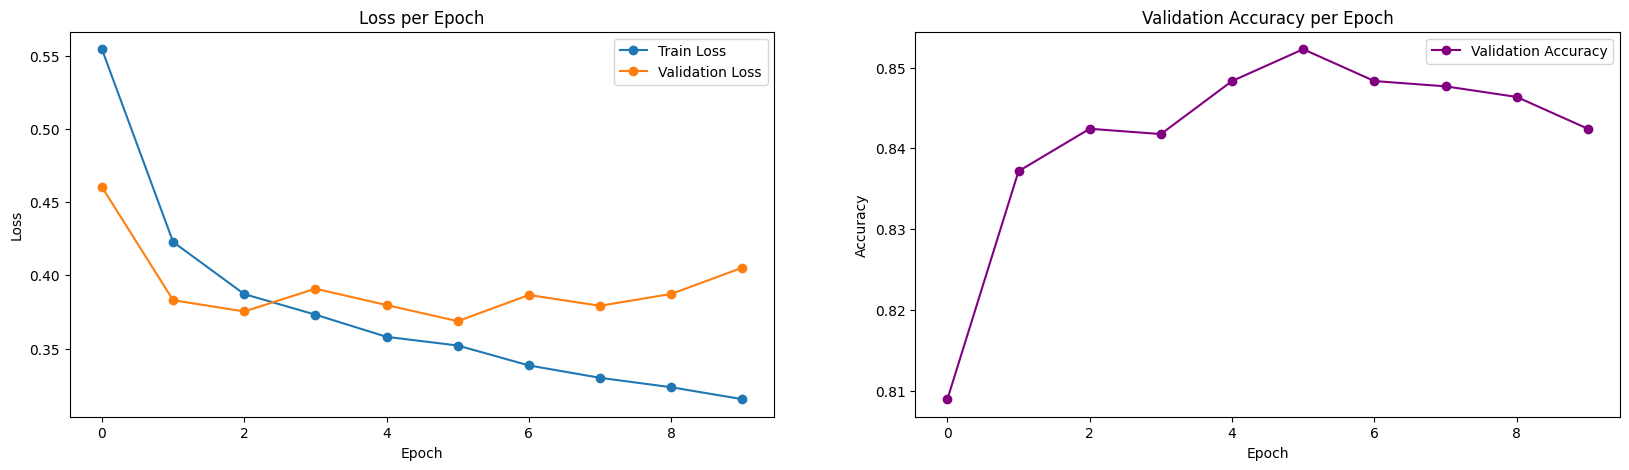

In [58]:
# 리스트 초기화: 손실 및 정확도 저장
train_losses = []
val_losses = []
accuracies = []

# 트레이닝 루프
epochs = 10  # 학습할 에포크 수
lora_model.train()  # 모델을 학습 모드로 설정

for epoch in range(epochs):  # 각 에포크마다 학습 진행
    total_loss = 0  # 에포크별 전체 손실 초기화
    optimizer.zero_grad()  # 옵티마이저의 기울기(gradient) 초기화

    # 트레이닝 데이터에 대해 배치 처리
    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
        # 배치에서 입력 데이터, 어텐션 마스크, 라벨 가져오기
        inputs, attention_masks, labels = batch
        inputs, attention_masks, labels = inputs.to(device), attention_masks.to(device), labels.to(device)  # 데이터를 GPU 또는 CPU로 이동

        # 자동 혼합 정밀도(AMP)를 사용하여 GPU에서 계산 효율성 향상
        with torch.amp.autocast('cuda'):
            # 모델에 입력 데이터를 전달하여 예측값을 얻음
            outputs = lora_model(input_ids=inputs, attention_mask=attention_masks).logits  # 'logits': 각 클래스에 대한 예측 점수

            # 손실 계산 및 그래디언트 축적을 위한 손실 나누기
            loss = loss_fn(outputs, labels) / accumulation_steps

        scaler.scale(loss).backward()  # 손실에 대해 역전파(그래디언트 계산)

        # 지정된 배치마다 그래디언트를 업데이트
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)  # 옵티마이저 단계 진행
            scaler.update()  # 스케일러 업데이트
            optimizer.zero_grad()  # 그래디언트 초기화

        total_loss += loss.item() * accumulation_steps  # 손실 누적

    avg_train_loss = total_loss / len(train_loader)  # 평균 훈련 손실 계산
    train_losses.append(avg_train_loss)  # 훈련 손실 저장

    # Validation 단계
    lora_model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0  # 검증 손실 초기화
    correct_predictions = 0  # 정확한 예측 수 초기화
    total_predictions = 0  # 총 예측 수 초기화

    # 검증 데이터셋에 대한 평가 (grad 계산 안함)
    with torch.no_grad():
        for batch in val_loader:
            # 배치에서 입력 데이터, 어텐션 마스크, 라벨 가져오기
            inputs, attention_masks, labels = batch
            inputs, attention_masks, labels = inputs.to(device), attention_masks.to(device), labels.to(device)

            # 자동 혼합 정밀도 사용
            with torch.amp.autocast('cuda'):
                # 모델에 입력 데이터를 전달하여 예측값을 얻음
                outputs = lora_model(input_ids=inputs, attention_mask=attention_masks).logits
                loss = loss_fn(outputs, labels)  # 손실 계산
                val_loss += loss.item() * inputs.size(0)  # 배치 손실 합산

                # 정확도 계산
                _, preds = torch.max(outputs, dim=1)  # 예측값 계산
                correct_predictions += torch.sum(preds == labels)  # 정확한 예측의 개수
                total_predictions += labels.size(0)  # 총 예측된 샘플 수

    avg_val_loss = val_loss / len(val_loader.dataset)  # 평균 검증 손실 계산
    accuracy = correct_predictions.double() / total_predictions  # 정확도 계산

    val_losses.append(avg_val_loss)  # 검증 손실 저장
    accuracies.append(accuracy.item())  # 정확도 저장

    # 에포크별 손실과 정확도 출력
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")

    # 학습률 스케줄러를 에포크마다 호출하여 학습률 조정
    step_scheduler.step()

    lora_model.train()  # 모델을 다시 학습 모드로 설정


# Loss 및 Accuracy 시각화
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Loss 그래프
axs[0].plot(train_losses, label='Train Loss', marker='o')
axs[0].plot(val_losses, label='Validation Loss', marker='o')
axs[0].set_title('Loss per Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Accuracy 그래프
axs[1].plot(accuracies, label='Validation Accuracy', marker='o', color='purple')
axs[1].set_title('Validation Accuracy per Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

# 모델 평가

Evaluating: 100%|██████████| 191/191 [01:21<00:00,  2.35it/s]


Validation Accuracy: 0.8424162836506894
Validation Precision: 0.8251192368839427
Validation Recall: 0.7996918335901386
Validation F1 Score: 0.8122065727699529


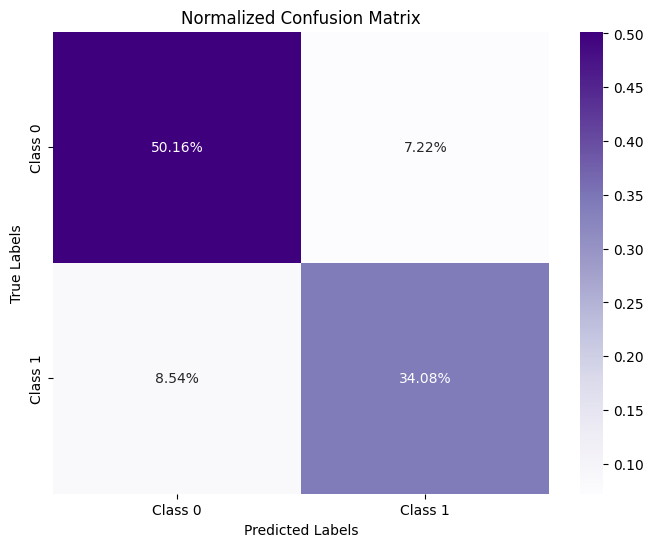

(0.8424162836506894,
 0.8251192368839427,
 0.7996918335901386,
 0.8122065727699529)

In [59]:
# 모델 평가 함수 정의
def evaluate_model(model, val_loader):
    model.eval()  # 모델을 평가 모드로 설정 
    all_labels = []  # 실제 라벨을 저장할 리스트
    all_preds = []   # 모델의 예측값을 저장할 리스트

    with torch.no_grad():  # 메모리 절약을 위해 그래디언트 계산을 비활성화 
        # 검증 데이터에 대해 배치 처리
        for batch in tqdm(val_loader, desc="Evaluating"):  
            inputs, attention_masks, labels = batch
            inputs, attention_masks, labels = inputs.to(device), attention_masks.to(device), labels.to(device)

            # 모델에 입력 데이터를 전달하여 예측 결과(logits)를 얻음
            outputs = model(input_ids=inputs, attention_mask=attention_masks).logits
            
            # 가장 높은 확률을 가진 클래스 예측
            preds = torch.argmax(outputs, dim=1)

            # 실제 라벨과 예측값을 리스트에 추가
            all_labels.extend(labels.cpu().numpy())  # 라벨을 CPU로 가져와 numpy 배열로 변환
            all_preds.extend(preds.cpu().numpy())    # 예측값을 CPU로 가져와 numpy 배열로 변환

    # accuracy, precision, recall, F1 score 계산
    accuracy = accuracy_score(all_labels, all_preds)  
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)  
    f1 = f1_score(all_labels, all_preds)  

    # 각 평가 지표 출력 
    print(f"Validation Accuracy: {accuracy}")
    print(f"Validation Precision: {precision}")
    print(f"Validation Recall: {recall}")
    print(f"Validation F1 Score: {f1}")

    # 혼동 행렬 계산
    cf_matrix = confusion_matrix(all_labels, all_preds)

    # 혼동 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Purples', 
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return accuracy, precision, recall, f1  # 평가 지표 반환

# 모델 평가 함수 호출
evaluate_model(lora_model, val_loader)


# 테스트 데이터셋에 대해 예측 수행 및 최종 결과 파일 저장

In [60]:
# 테스트 데이터셋에 대한 예측 수행
def predict_test(model, test_loader):
    model.eval()  # 모델을 평가 모드로 설정 (dropout, batchnorm 비활성화)
    predictions = []  # 예측 결과를 저장할 리스트

    with torch.no_grad():  # 메모리 절약을 위해 그래디언트 계산을 비활성화 
        # 테스트 데이터에 대해 배치 처리
        for batch in tqdm(test_loader, desc="Predicting"):  
            inputs, attention_masks = batch
            inputs, attention_masks = inputs.to(device), attention_masks.to(device)  

            # 모델에 입력 데이터를 전달하여 예측 결과 얻기
            outputs = model(input_ids=inputs, attention_mask=attention_masks).logits

            # 예측값에서 가장 높은 확률을 가진 클래스를 선택
            preds = torch.argmax(outputs, dim=1)

            # 예측 결과를 리스트에 추가
            predictions.extend(preds.cpu().numpy())

    return predictions  # 최종 예측값 반환


In [61]:
# 모델을 사용하여 테스트 데이터에 대한 예측 수행
test_predictions = predict_test(lora_model, test_loader)

# 예측 결과 CSV 파일로 저장
submission_df = pd.DataFrame({
    'id': test_df['id'],  # 'id' 열이 test_df에 있다고 가정
    'target': test_predictions
})

submission_df.to_csv('submission.csv', index=False)

Predicting: 100%|██████████| 408/408 [02:53<00:00,  2.35it/s]
